The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.0-alpha1.post0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.2 MB/s 
     |████████████████████████████████| 120 kB 21.8 MB/s 
     |████████████████████████████████| 1.6 MB 54.0 MB/s 
     |████████████████████████████████| 82 kB 763 kB/s 


# Machine Translation and the Dataset
:label:`sec_machine_translation`

Among the major breakthroughs that prompted 
widespread interest in modern RNNs
was a major advance in the applied field of 
statistical  *machine translation*.
Here, the model is presented with a sentence in one language
and must predict the corresponding sentence in another language. 
Note that here the sentences may be of different lengths,
and that corresponding words in the two sentences 
may not occur in the same order, 
owing to differences 
in the two language's grammatical structure. 


Many problems have this flavor of mapping 
between two such "unaligned" sequences.
Examples include mapping 
from dialog prompts to replies
or from questions to answers.
Broadly, such problems are called 
*sequence-to-sequence* (seq2seq) problems 
and they are our focus for 
both the remainder of this chapter
and much of :numref:`chap_attention-and-transformers`.

In this section, we introduce the machine translation problem
and an example dataset that we will use in the subsequent examples.
For decades, statistical formulations of translation between languages
had been popular :cite:`Brown.Cocke.Della-Pietra.ea.1988,Brown.Cocke.Della-Pietra.ea.1990`,
even before researchers got neural network approaches working
(methods often lumped together under the term *neural machine translation*).


First we will need some new code to process our data.
Unlike the language modeling that we saw in :numref:`sec_language-model`,
here each example consists of two separate text sequences,
one in the source language and another (the translation) in the target language.
The following code snippets will show how 
to load the preprocessed data into minibatches for training.


In [2]:
import os
import torch
from d2l import torch as d2l

## [**Downloading and Preprocessing the Dataset**]

To begin, we download an English-French dataset
that consists of [bilingual sentence pairs from the Tatoeba Project](http://www.manythings.org/anki/).
Each line in the dataset is a tab-delimited pair 
consisting of an English text sequence 
and the translated French text sequence.
Note that each text sequence
can be just one sentence,
or a paragraph of multiple sentences.
In this machine translation problem
where English is translated into French,
English is called the *source language*
and French is called the *target language*.


In [3]:
class MTFraEng(d2l.DataModule):  #@save
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

data = MTFraEng()
raw_text = data._download()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



After downloading the dataset,
we [**proceed with several preprocessing steps**]
for the raw text data.
For instance, we replace non-breaking space with space,
convert uppercase letters to lowercase ones,
and insert space between words and punctuation marks.


In [4]:
@d2l.add_to_class(MTFraEng)  #@save
def _preprocess(self, text):
    # Replace non-breaking space with space
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    # Insert space between words and punctuation marks
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    return ''.join(out)

text = data._preprocess(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## [**Tokenization**]

Unlike the character-level tokenization
in :numref:`sec_language-model`,
for machine translation
we prefer word-level tokenization here
(today's state-of-the-art models use 
more complex tokenization techniques).
The following `_tokenize` method
tokenizes the first `max_examples` text sequence pairs,
where each token is either a word or a punctuation mark.
We append the special “&lt;eos&gt;” token
to the end of every sequence to indicate the
end of the sequence.
When a model is predicting
by generating a sequence token after token,
the generation of the “&lt;eos&gt;” token
can suggest that the output sequence is complete.
In the end, the method below returns
two lists of token lists: `src` and `tgt`.
Specifically, `src[i]` is a list of tokens from the
$i^\mathrm{th}$ text sequence in the source language (English here) 
and `tgt[i]` is that in the target language (French here).


In [5]:
@d2l.add_to_class(MTFraEng)  #@save
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            # Skip empty tokens
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
            tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

src, tgt = data._tokenize(text)
src[:6], tgt[:6]

([['go', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '!', '<eos>'],
  ['who', '?', '<eos>'],
  ['wow', '!', '<eos>']],
 [['va', '!', '<eos>'],
  ['salut', '!', '<eos>'],
  ['cours', '!', '<eos>'],
  ['courez', '!', '<eos>'],
  ['qui', '?', '<eos>'],
  ['ça', 'alors', '!', '<eos>']])

Let's [**plot the histogram of the number of tokens per text sequence.**]
In this simple English-French dataset,
most of the text sequences have fewer than 20 tokens.


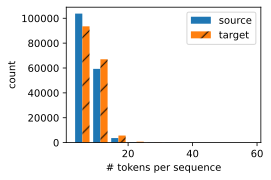

In [6]:
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', src, tgt);

## Loading Sequences of Fixed Length
:label:`subsec_loading-seq-fixed-len`

Recall that in language modeling
[**each example sequence**],
either a segment of one sentence
or a span over multiple sentences,
(**had a fixed length.**)
This was specified by the `num_steps`
(number of time steps or tokens) argument in :numref:`sec_language-model`.
In machine translation, each example is
a pair of source and target text sequences,
where the two text sequences may have different lengths.

For computational efficiency,
we can still process a minibatch of text sequences
at one time by *truncation* and *padding*.
Suppose that every sequence in the same minibatch
should have the same length `num_steps`.
If a text sequence has fewer than `num_steps` tokens,
we will keep appending the special "&lt;pad&gt;" token
to its end until its length reaches `num_steps`.
Otherwise, we will truncate the text sequence
by only taking its first `num_steps` tokens
and discarding the remaining.
In this way, every text sequence
will have the same length
to be loaded in minibatches of the same shape.
Besides, we also record length of the source sequence excluding padding tokens.
This information will be needed by some models that we will cover later.


Since the machine translation dataset
consists of pairs of languages,
we can build two vocabularies for
both the source language and
the target language separately.
With word-level tokenization,
the vocabulary size will be significantly larger
than that using character-level tokenization.
To alleviate this,
here we treat infrequent tokens
that appear less than 2 times
as the same unknown ("&lt;unk&gt;") token.
As we will explain later (:numref:`fig_seq2seq`),
when training with target sequences,
the decoder output (label tokens)
can be the same decoder input (target tokens),
shifted by one token;
and the special beginning-of-sequence "&lt;bos&gt;" token
will be used as the first input token
for predicting the target sequence (:numref:`fig_seq2seq_predict`).


In [7]:
@d2l.add_to_class(MTFraEng)  #@save
def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
        self._download())


@d2l.add_to_class(MTFraEng)  #@save
def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (
            seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
        return array, vocab, valid_len
    src, tgt = self._tokenize(self._preprocess(raw_text),
                              self.num_train + self.num_val)
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
            src_vocab, tgt_vocab)

## [**Reading the Dataset**]

Finally, we define the `get_dataloader` method
to return the data iterator.


In [8]:
@d2l.add_to_class(MTFraEng)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)

Let's [**read the first minibatch from the English-French dataset.**]


In [9]:
data = MTFraEng(batch_size=3)
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print('source:', src.type(torch.int32))
print('decoder input:', tgt.type(torch.int32))
print('source len excluding pad:', src_valid_len.type(torch.int32))
print('label:', label.type(torch.int32))

source: tensor([[ 28, 125,   2,   3,   4,   4,   4,   4,   4],
        [101,  91,   2,   3,   4,   4,   4,   4,   4],
        [ 40,  91,   0,   3,   4,   4,   4,   4,   4]], dtype=torch.int32)
decoder input: tensor([[  3, 206,  47, 129,   0,   4,   5,   5,   5],
        [  3, 115, 193,   0,   4,   5,   5,   5,   5],
        [  3,   6, 193,   0,   4,   5,   5,   5,   5]], dtype=torch.int32)
source len excluding pad: tensor([4, 4, 4], dtype=torch.int32)
label: tensor([[206,  47, 129,   0,   4,   5,   5,   5,   5],
        [115, 193,   0,   4,   5,   5,   5,   5,   5],
        [  6, 193,   0,   4,   5,   5,   5,   5,   5]], dtype=torch.int32)


Below we show a pair of source and target sequences
that are processed by the above `_build_arrays` method
(in the string format).


In [10]:
@d2l.add_to_class(MTFraEng)  #@save
def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
        src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(
        raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

In [11]:
src, tgt, _,  _ = data.build(['hi .'], ['salut .'])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


## Summary

In natural language processing, *machine translation* refers to the task of automatically mapping from a sequence representing a string of text in a *source* language to a string representing a plausible translation in a *target* language. Using word-level tokenization, the vocabulary size will be significantly larger than that using character-level tokenization, but the sequence lengths will be much shorter. To mitigate the large vocabulary size, we can treat infrequent tokens as some "unknown" token. We can truncate and pad text sequences so that all of them will have the same length to be loaded in minibatches. Modern implementations often bucket sequences with similar lengths to avoid wasting excessive computation on padding. 


## Exercises

1. Try different values of the `max_examples` argument in the `_tokenize` method. How does this affect the vocabulary sizes of the source language and the target language?
1. Text in some languages such as Chinese and Japanese does not have word boundary indicators (e.g., space). Is word-level tokenization still a good idea for such cases? Why or why not?


[Discussions](https://discuss.d2l.ai/t/1060)
